## Setup

In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
FORCE_CPU = False
SEED = 2384

HIDDEN_SIZE = 16
TASK_TRAIN_SIZE = 100000
TASK_TEST_SIZE = 1000
TASK_LR = 0.01
TASK_EPOCHS = 10000
TASK_SCHEDULER_PATIENCE = 1000

SAVE_MODEL = False
LOAD_MODEL = True
MODEL_PATH = "saved_models/hierarchical-equality.pt"

In [3]:
import random
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import pandas as pd

import networkx as nx

import tqdm

from transformer_lens.hook_points import HookedRootModule, HookPoint

from causal_networks.dag import DeterministicDAG
from causal_networks.variable_alignment import VariableAlignment

In [4]:
if not FORCE_CPU and torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cpu


/home/sam/.virtualenvs/causal-networks/lib/python3.11/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


## Training the model

In [5]:
@dataclass
class Config:
    input_size: int = 4
    hidden_size: int = 16
    output_size: int = 2

In [6]:
# Create a three layer hooked MLP
class MLP(HookedRootModule):
    def __init__(self, cfg: Config):
        super().__init__()

        self.cfg = cfg

        self.hook_pre1 = HookPoint()
        self.layer1 = nn.Linear(cfg.input_size, cfg.hidden_size, bias=True)
        self.hook_mid1 = HookPoint()
        self.hook_pre2 = HookPoint()
        self.layer2 = nn.Linear(cfg.hidden_size, cfg.hidden_size, bias=True)
        self.hook_mid2 = HookPoint()
        self.hook_pre3 = HookPoint()
        self.layer3 = nn.Linear(cfg.hidden_size, cfg.output_size, bias=True)
        self.hook_mid3 = HookPoint()
        self.hook_post = HookPoint()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.hook_pre1(x)
        x = self.hook_mid1(self.layer1(x))
        x = self.relu(x)
        x = self.hook_pre2(x)
        x = self.hook_mid2(self.layer2(x))
        x = self.relu(x)
        x = self.hook_pre3(x)
        x = self.hook_mid3(self.layer3(x))
        x = self.softmax(x)
        x = self.hook_post(x)
        return x

In [7]:
# define the model
model = MLP(Config(hidden_size=HIDDEN_SIZE))
model.setup()

print(model)

MLP(
  (hook_pre1): HookPoint()
  (layer1): Linear(in_features=4, out_features=16, bias=True)
  (hook_mid1): HookPoint()
  (hook_pre2): HookPoint()
  (layer2): Linear(in_features=16, out_features=16, bias=True)
  (hook_mid2): HookPoint()
  (hook_pre3): HookPoint()
  (layer3): Linear(in_features=16, out_features=2, bias=True)
  (hook_mid3): HookPoint()
  (hook_post): HookPoint()
  (relu): ReLU()
  (softmax): Softmax(dim=-1)
)


In [8]:
def generate_grouped_data(n):
    """Generates n data points with 4 balanced groups,
       (w==x, y==z), (w==x, y!=z), (w!=x, y==z), (w!=x, y!=z)
       For the heirarchical equality task""" 
    
    # Initialize the empty list for data and labels
    data, labels = [], []
    for i in range(n):
        # Define a pattern for each group based on the remainder when i is divided by 4
        group_pattern = i % 4
        
        # Depending on the pattern, generate w, x, y, z
        if group_pattern == 0:  # w==x, y!=z
            w = x = np.random.uniform(-0.5, 0.5)
            y, z = np.random.uniform(-0.5, 0.5, 2)
        elif group_pattern == 1:  # w==x, y==z
            w = x = np.random.uniform(-0.5, 0.5)
            y = z = np.random.uniform(-0.5, 0.5)
        elif group_pattern == 2:  # w!=x, y==z
            w, x = np.random.uniform(-0.5, 0.5, 2)
            y = z = np.random.uniform(-0.5, 0.5)
        elif group_pattern == 3:  # w!=x, y!=z
            w, x, y, z = np.random.uniform(-0.5, 0.5, 4)
        
        # Decide the label based on the given condition
        label = 1 if (w == x) == (y == z) else 0

        # Append the generated data and label to the respective lists
        data.append([w, x, y, z])
        labels.append(label)

    # Convert the lists to numpy arrays for further processing
    data = np.array(data)
    labels = np.array(labels)

    return data, labels


In [9]:
# generate the data
data, labels = generate_grouped_data(100000)

In [10]:
# train the network

# set the random seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if LOAD_MODEL:

    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

else:

    # define the loss function and the optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=TASK_LR)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=TASK_SCHEDULER_PATIENCE, verbose=True)

    # convert the data and labels to torch tensors
    data, labels = generate_grouped_data(TASK_TRAIN_SIZE)
    data = torch.from_numpy(data).float()
    labels = torch.from_numpy(labels).long()

    val_data, val_labels = generate_grouped_data(TASK_TEST_SIZE)
    val_data = torch.from_numpy(val_data).float()
    val_labels = torch.from_numpy(val_labels).long()

    data = data.to(device)
    labels = labels.to(device)
    val_data = val_data.to(device)
    val_labels = val_labels.to(device)
    model = model.to(device)

    # train the model
    for epoch in range(TASK_EPOCHS):
        # forward pass
        outputs = model(data)
        loss = criterion(outputs, labels)
        
        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        
        if (epoch+1) % 100 == 0:
            print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, TASK_EPOCHS, loss.item()))

    # test the model
    with torch.no_grad():
        # forward pass
        outputs = model(val_data)
        _, predicted = torch.max(outputs.data, 1)

        # compute the accuracy
        total = val_labels.size(0)
        correct = (predicted == val_labels).sum().item()
        print('Accuracy of the network on the test data: {} %'.format(100 * correct / total))

In [11]:
if SAVE_MODEL:
    torch.save(model.state_dict(), MODEL_PATH)

## Causal DAGS

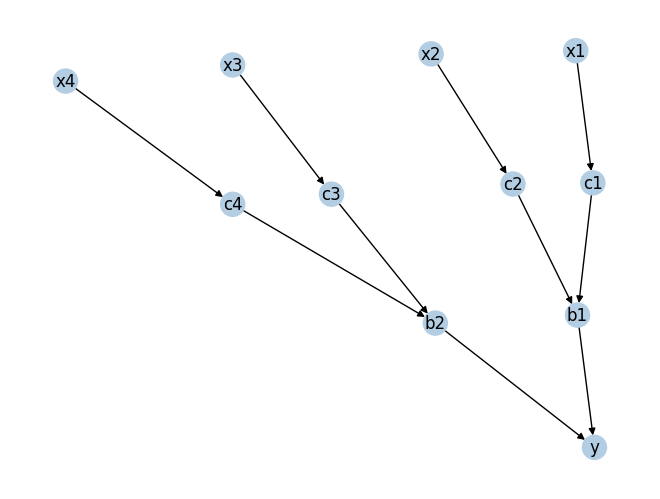

                        Node Information                         
┏━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Node ┃ Function     ┃ Sampler       ┃ Validator       ┃ Value ┃
┡━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ x1   │ -            │ float_sampler │ float_validator │ -     │
│ x2   │ -            │ float_sampler │ float_validator │ -     │
│ x3   │ -            │ float_sampler │ float_validator │ -     │
│ x4   │ -            │ float_sampler │ float_validator │ -     │
│ c1   │ copy_func    │ float_sampler │ float_validator │ -     │
│ c2   │ copy_func    │ float_sampler │ float_validator │ -     │
│ c3   │ copy_func    │ float_sampler │ float_validator │ -     │
│ c4   │ copy_func    │ float_sampler │ float_validator │ -     │
│ b1   │ compare_func │ bool_sampler  │ bool_validator  │ -     │
│ b2   │ compare_func │ bool_sampler  │ bool_validator  │ -     │
│ y    │ compare_func │ bool_sampler  │ bool_validator  │ -     │
└──────┴──────────────┴───────────────┴─────────────────┴───────┘

In [58]:
def float_validator(value):
    return -0.5 <= value <= 0.5

def float_sampler():
    return random.uniform(-0.5, 0.5)

def bool_validator(value):
    return value in {True, False}

def bool_sampler():
    return random.choice([True, False])

def copy_func(x):
    return x

def compare_func(value1, value2):
    return value1 == value2

dag = DeterministicDAG()

# Define the nodes
dag.add_node('x1', validator=float_validator, sampler=float_sampler)
dag.add_node('x2', validator=float_validator, sampler=float_sampler)
dag.add_node('x3', validator=float_validator, sampler=float_sampler)
dag.add_node('x4', validator=float_validator, sampler=float_sampler)
dag.add_node('c1', func=copy_func, validator=float_validator, sampler=float_sampler)
dag.add_node('c2', func=copy_func, validator=float_validator, sampler=float_sampler)
dag.add_node('c3', func=copy_func, validator=float_validator, sampler=float_sampler)
dag.add_node('c4', func=copy_func, validator=float_validator, sampler=float_sampler)
dag.add_node('b1', func=compare_func, validator=bool_validator, sampler=bool_sampler)
dag.add_node('b2', func=compare_func, validator=bool_validator, sampler=bool_sampler)
dag.add_node('y', func=compare_func, validator=bool_validator, sampler=bool_sampler, possible_values=[True, False])

# Define the edges
edges = [('x1', 'c1'), ('x2', 'c2'), ('x3', 'c3'), ('x4', 'c4'), 
         ('c1', 'b1'), ('c2', 'b1'), ('c3', 'b2'), ('c4', 'b2'), 
         ('b1', 'y'), ('b2', 'y')]
for edge in edges:
    dag.add_edge(*edge)

dag.visualize()

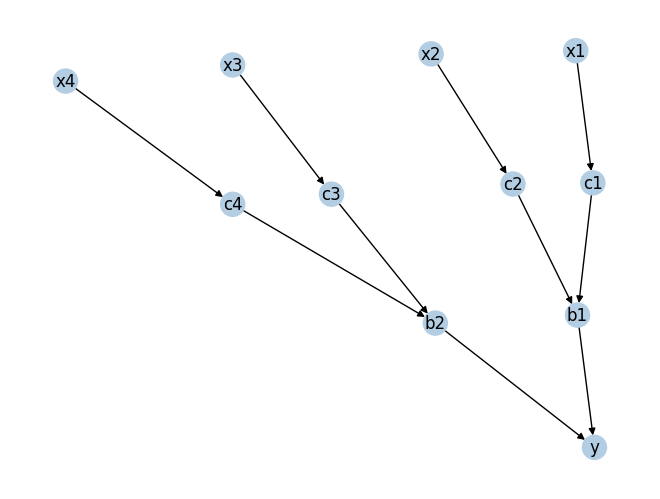

                        Node Information                         
┏━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Node ┃ Function     ┃ Sampler       ┃ Validator       ┃ Value ┃
┡━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ x1   │ -            │ float_sampler │ float_validator │ 0.1   │
│ x2   │ -            │ float_sampler │ float_validator │ 0.2   │
│ x3   │ -            │ float_sampler │ float_validator │ 0.3   │
│ x4   │ -            │ float_sampler │ float_validator │ 0.4   │
│ c1   │ copy_func    │ float_sampler │ float_validator │ 0.1   │
│ c2   │ copy_func    │ float_sampler │ float_validator │ 0.2   │
│ c3   │ copy_func    │ float_sampler │ float_validator │ 0.3   │
│ c4   │ copy_func    │ float_sampler │ float_validator │ 0.4   │
│ b1   │ compare_func │ bool_sampler  │ bool_validator  │ False │
│ b2   │ compare_func │ bool_sampler  │ bool_validator  │ False │
│ y    │ compare_func │ bool_sampler  │ bool_validator  │ True  │
└──────┴──────────────┴───────────────┴─────────────────┴───────┘

In [59]:
dag.run(dict(x1=0.1, x2=0.2, x3=0.3, x4=0.4))
dag.visualize()

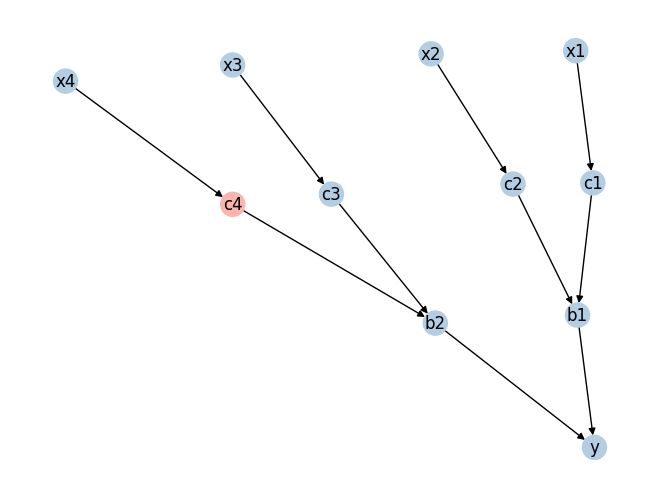

                        Node Information                         
┏━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Node ┃ Function     ┃ Sampler       ┃ Validator       ┃ Value ┃
┡━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ x1   │ -            │ float_sampler │ float_validator │ 0.1   │
│ x2   │ -            │ float_sampler │ float_validator │ 0.2   │
│ x3   │ -            │ float_sampler │ float_validator │ 0.3   │
│ x4   │ -            │ float_sampler │ float_validator │ 0.4   │
│ c1   │ copy_func    │ float_sampler │ float_validator │ 0.1   │
│ c2   │ copy_func    │ float_sampler │ float_validator │ 0.2   │
│ c3   │ copy_func    │ float_sampler │ float_validator │ 0.3   │
│ c4   │ copy_func    │ float_sampler │ float_validator │ 0.3   │
│ b1   │ compare_func │ bool_sampler  │ bool_validator  │ False │
│ b2   │ compare_func │ bool_sampler  │ bool_validator  │ True  │
│ y    │ compare_func │ bool_sampler  │ bool_validator  │ False │
└──────┴──────────────┴───────────────┴─────────────────┴───────┘

In [60]:
dag.intervene_and_run("c4", 0.3, dict(x1=0.1, x2=0.2, x3=0.3, x4=0.4))
dag.visualize()

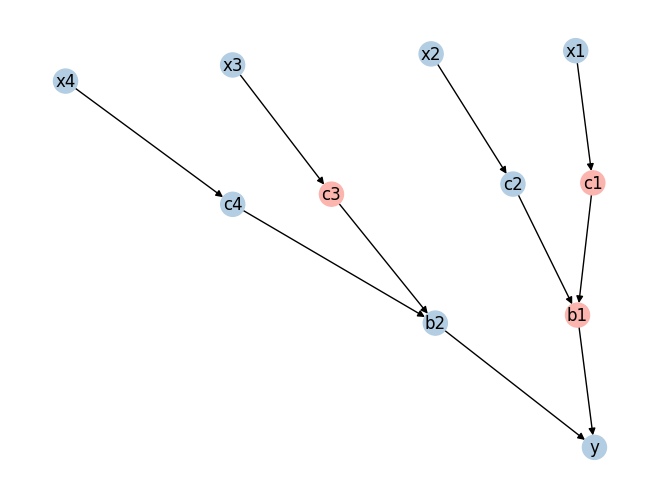

                        Node Information                         
┏━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Node ┃ Function     ┃ Sampler       ┃ Validator       ┃ Value ┃
┡━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ x1   │ -            │ float_sampler │ float_validator │ -     │
│ x2   │ -            │ float_sampler │ float_validator │ -     │
│ x3   │ -            │ float_sampler │ float_validator │ -     │
│ x4   │ -            │ float_sampler │ float_validator │ -     │
│ c1   │ copy_func    │ float_sampler │ float_validator │ 0.1   │
│ c2   │ copy_func    │ float_sampler │ float_validator │ -     │
│ c3   │ copy_func    │ float_sampler │ float_validator │ 0.3   │
│ c4   │ copy_func    │ float_sampler │ float_validator │ -     │
│ b1   │ compare_func │ bool_sampler  │ bool_validator  │ True  │
│ b2   │ compare_func │ bool_sampler  │ bool_validator  │ -     │
│ y    │ compare_func │ bool_sampler  │ bool_validator  │ -     │
└──────┴──────────────┴───────────────┴─────────────────┴───────┘

In [61]:
dag.do_interchange_intervention(
    [["b1", "c1"], ["c3"]],
    [dict(x1=0.1, x2=0.1, x3=0.1, x4=0.1), dict(x1=0.5, x2=0.4, x3=0.3, x4=0.2)],
)
dag.visualize()

In [62]:
def input_alignment(x: torch.tensor):
    if x.ndim == 1:
        return dict(x1=x[0].item(), x2=x[1].item(), x3=x[2].item(), x4=x[3].item())
    elif x.ndim == 2 and x.shape[0] == 1:
        return dict(x1=x[0, 0].item(), x2=x[0, 1].item(), x3=x[0, 2].item(), x4=x[0, 3].item())
    elif x.ndim == 2:
        return [
            dict(
                x1=x[i, 0].item(),
                x2=x[i, 1].item(),
                x3=x[i, 2].item(),
                x4=x[i, 3].item(),
            )
            for i in range(x.shape[0])
        ]
    else:
        raise ValueError("Invalid input shape")


def output_alignment(y: torch.tensor):
    return dict(y=torch.argmax(y).item())


variable_alignment = VariableAlignment(
    dag=dag,
    low_level_model=model,
    dag_nodes=["c1", "c2", "c3", "c4", "b1", "b2"],
    input_alignment=input_alignment,
    output_alignment=output_alignment,
    intervene_model_hooks=["hook_pre2"],
    subspaces_sizes=[1, 1, 1, 1, 1, 1],
    verbosity=2,
)

Running model to determine activation space size...


In [63]:
model

MLP(
  (hook_pre1): HookPoint()
  (layer1): Linear(in_features=4, out_features=16, bias=True)
  (hook_mid1): HookPoint()
  (hook_pre2): HookPoint()
  (layer2): Linear(in_features=16, out_features=16, bias=True)
  (hook_mid2): HookPoint()
  (hook_pre3): HookPoint()
  (layer3): Linear(in_features=16, out_features=2, bias=True)
  (hook_mid3): HookPoint()
  (hook_post): HookPoint()
  (relu): ReLU()
  (softmax): Softmax(dim=-1)
)

In [64]:
base_input = torch.rand(1, 4) - 0.5
source_inputs = torch.rand(6, 4) - 0.5
variable_alignment.get_distributed_interchange_intervention_hooks(base_input, source_inputs)

Running model to determine activation values on source inputs...


[('hook_pre2',
  functools.partial(<function VariableAlignment.get_distributed_interchange_intervention_hooks.<locals>.intervention_hook at 0x7f8e4b10fce0>, space_index=0, new_activation_values=tensor([ -0.2347,  11.5100, -19.5075,  18.1013,  16.1491,  34.1363, -11.2903,
           13.3813,   3.0705,  -0.4488,   7.2511,   7.4377,  26.6541,   1.2838,
           -4.2323,   8.0897], grad_fn=<SqueezeBackward4>)))]

In [65]:
variable_alignment.run_distributed_interchange_intervention(base_input, source_inputs)

Running model to determine activation values on source inputs...


tensor([0., 1.], grad_fn=<SoftmaxBackward0>)

In [69]:
variable_alignment.run_interchange_intervention(base_input, source_inputs)

tensor([[1, 0]])